# Lightweight Fine-Tuning Project

Below I list the PEFT technique, the model, evaluation approach and fine-tunning dataset I'll be using to fine tune the LLM
* PEFT technique: LoRA
* Model: GPT-2
* Evaluation approach: Hugging Face Trainer.evaluate
* Fine-tuning dataset: [AuthorMix](https://huggingface.co/datasets/hallisky/AuthorMix)

## Loading and Evaluating a Foundation Model

Loading GPT-2 model and evaluate its performance prior to fine-tuning. This includes loading an appropriate tokenizer and dataset.

## Load in AuthorMix Dataset

In [ ]:
# Install dependencies (if not in conda env)
!pip install -q "datasets>=2.16.1"
!pip install torch
!pip install transformers==4.44.1
!pip install python-dotenv
!pip install peft
!pip install evaluate

In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from dotenv import load_dotenv
from huggingface_hub import login
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from eval_utils import get_prediction, evaluate_model
from training_utils import get_lora_target_modules
from peft import get_peft_model, LoraConfig, TaskType
from pre_process_utils import preprocess_function, tokenize_splits
from functools import partial
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
from training_utils import generate_training_args, compute_metrics, create_validation_split
from trainer_generator import generate_trainer

In [6]:
# Load the train and test splits of the AuthorMix dataset
splits = ["train", "test"]
ds = {
    split: ds for split,
    ds in zip(splits, load_dataset("hallisky/AuthorMix", split=splits))
}

# Thin out the dataset to make it run faster for this example
for split in splits:
    ds[split] = ds[split].shuffle(seed=42).select(range(1000))

# Show the dataset
ds

{'train': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 1000
 }),
 'test': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 1000
 })}

### Dataset Exploration

In [7]:
train_df = pd.DataFrame(ds['train'])

print(train_df.head())

       style                                               text category
0  blog11518  "Jamaia....come and help me talk some sense in...     blog
1  blog25872  I decided I wasn't going to go to Boler today....     blog
2      obama  For over two decades, bin Laden has been al Qa...   speech
3  blog11518  motion with precise timing. Sucking the cigare...     blog
4  blog11518  "So what, we just stand here?" Alyx prompts, h...     blog


The dataset contains 14 unique authors

In [8]:
unique_styles = train_df['style'].unique()
print(unique_styles)

['blog11518' 'blog25872' 'obama' 'fitzgerald' 'hemingway' 'woolf' 'bush'
 'blog30102' 'blog5546' 'trump' 'blog30407' 'qq' 'pp' 'h']


In 4 number of formats/categories

In [9]:
unique_formats = train_df['category'].unique()
print(unique_formats)

['blog' 'speech' 'author' 'amt']


Dataset sample text length just skew towards 335 characters or less 

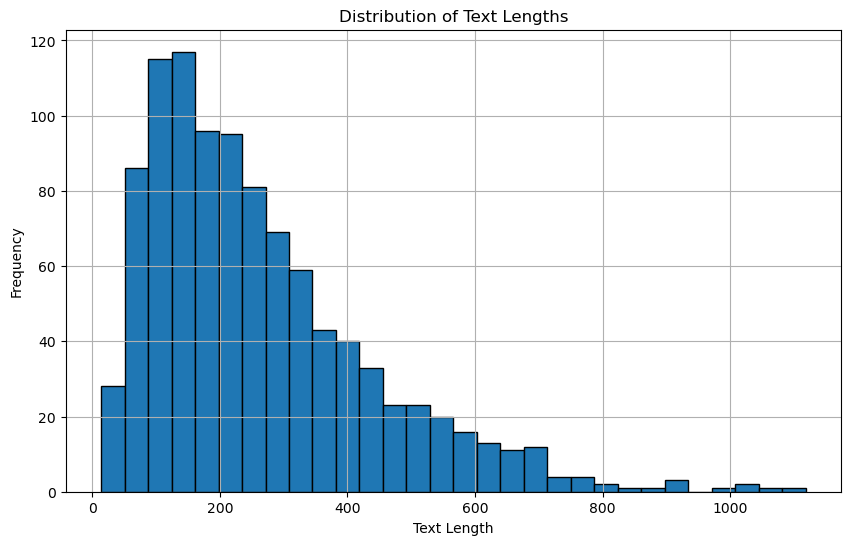

In [10]:
train_df['text_length'] = train_df['text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=30, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

I'm going to make an assumption that there isn't enough data in entries that only have a text length less than say 200 characters so I'm going to filter those out.

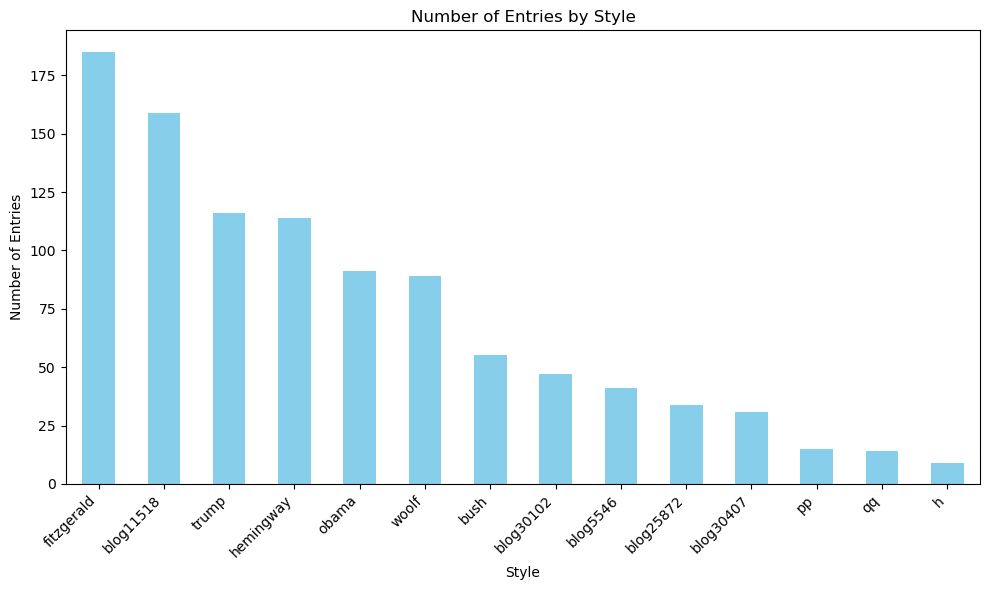

In [11]:
styles = [entry['style'] for entry in ds['test']]

# Count the number of entries for each style using pandas
df = pd.DataFrame(styles, columns=['Style'])
style_counts = df['Style'].value_counts()

# Plot the data
plt.figure(figsize=(10, 6))
style_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Entries by Style')
plt.xlabel('Style')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
data = [(entry['style'], entry['category']) for entry in ds['test']]

df = pd.DataFrame(data, columns=['Style', 'Category'])

category_counts_by_style = df.groupby(['Style', 'Category']).size().reset_index(name='Count')

print(category_counts_by_style)

distinct_categories_by_style = df.groupby('Style')['Category'].nunique().reset_index(name='Distinct Categories')

print(distinct_categories_by_style)

         Style Category  Count
0    blog11518     blog    159
1    blog25872     blog     34
2    blog30102     blog     47
3    blog30407     blog     31
4     blog5546     blog     41
5         bush   speech     55
6   fitzgerald   author    185
7            h      amt      9
8    hemingway   author    114
9        obama   speech     91
10          pp      amt     15
11          qq      amt     14
12       trump   speech    116
13       woolf   author     89
         Style  Distinct Categories
0    blog11518                    1
1    blog25872                    1
2    blog30102                    1
3    blog30407                    1
4     blog5546                    1
5         bush                    1
6   fitzgerald                    1
7            h                    1
8    hemingway                    1
9        obama                    1
10          pp                    1
11          qq                    1
12       trump                    1
13       woolf                 

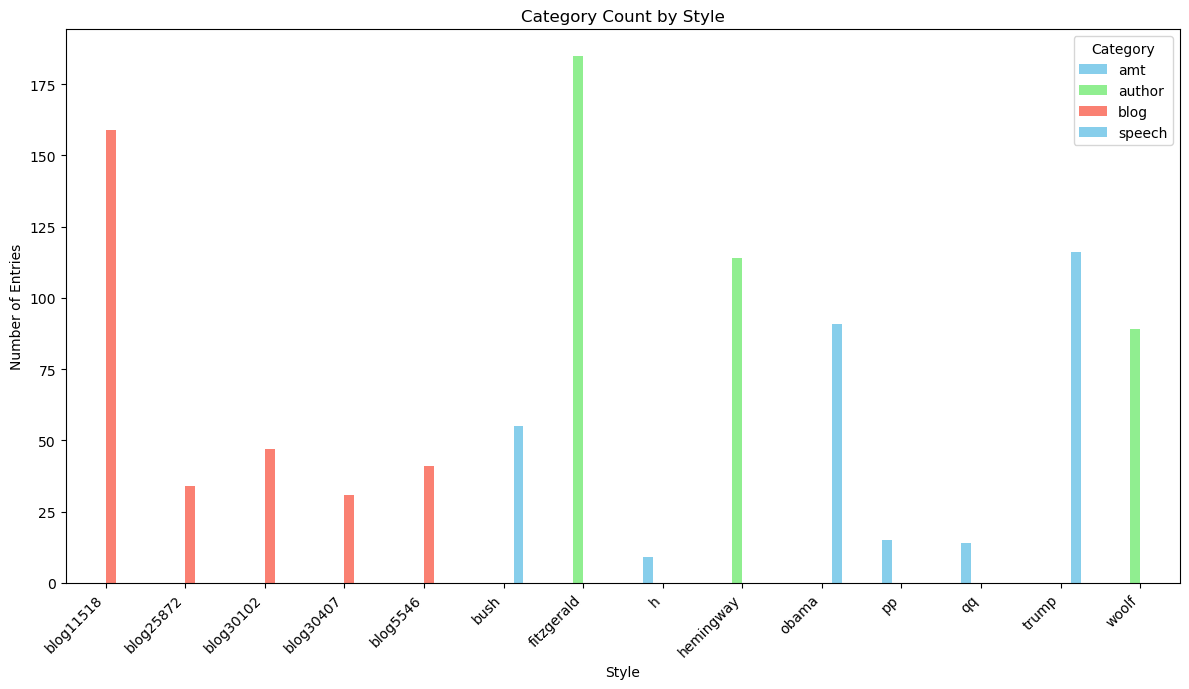

In [13]:
data = [(entry['style'], entry['category']) for entry in ds['test']]

df = pd.DataFrame(data, columns=['Style', 'Category'])

category_counts_by_style = df.groupby(['Style', 'Category']).size().unstack(fill_value=0)

category_counts_by_style.plot(kind='bar', stacked=False, figsize=(12, 7), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Category Count by Style')
plt.xlabel('Style')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

         Style  Average Text Length
0    blog11518           231.452830
1    blog25872           169.441176
2    blog30102           192.765957
3    blog30407           214.354839
4     blog5546           254.951220
5         bush           376.381818
6   fitzgerald           304.400000
7            h           484.777778
8    hemingway           187.789474
9        obama           393.439560
10          pp           375.066667
11          qq           493.928571
12       trump           256.250000
13       woolf           401.955056


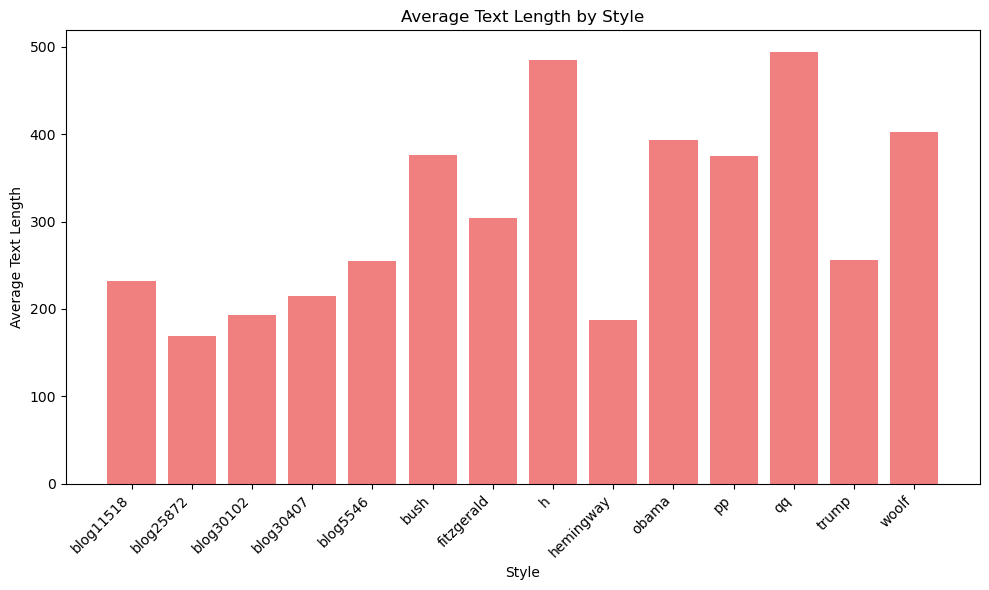

In [14]:
# Extract the "style" and "text" fields from the dataset
data = [(entry['style'], entry['text']) for entry in ds['test']]

df = pd.DataFrame(data, columns=['Style', 'Text'])

df['Text_Length'] = df['Text'].apply(lambda x: len(x) if isinstance(x, str) else sum(len(t) for t in x))

avg_text_length_by_style = df.groupby('Style')['Text_Length'].mean().reset_index(name='Average Text Length')

print(avg_text_length_by_style)

# Plot the average text length by style
plt.figure(figsize=(10, 6))
plt.bar(avg_text_length_by_style['Style'], avg_text_length_by_style['Average Text Length'], color='lightcoral')
plt.title('Average Text Length by Style')
plt.xlabel('Style')
plt.ylabel('Average Text Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Intial GPT-2 evaluation on the dataset
Going to load in the GPT-2 model through AutoModelForSequenceClassification and set the label ids

In [15]:
load_dotenv("env.txt")
hf_token = os.getenv('HF_API_TOKEN')
login(hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/david/.cache/huggingface/token
Login successful


In [16]:
num_labels = len(unique_styles)
id2label = {i: style for i, style in enumerate(unique_styles)}
label2id = {v: k for k, v in id2label.items()}
print(f"num_labels: {num_labels}")
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")
gpt_model_key = "openai-community/gpt2"
gpt_model = AutoModelForSequenceClassification.from_pretrained(
    gpt_model_key,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    token=True,
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


num_labels: 14
id2label: {0: 'blog11518', 1: 'blog25872', 2: 'obama', 3: 'fitzgerald', 4: 'hemingway', 5: 'woolf', 6: 'bush', 7: 'blog30102', 8: 'blog5546', 9: 'trump', 10: 'blog30407', 11: 'qq', 12: 'pp', 13: 'h'}
label2id: {'blog11518': 0, 'blog25872': 1, 'obama': 2, 'fitzgerald': 3, 'hemingway': 4, 'woolf': 5, 'bush': 6, 'blog30102': 7, 'blog5546': 8, 'trump': 9, 'blog30407': 10, 'qq': 11, 'pp': 12, 'h': 13}


In [17]:
# Tokenizer setup
# GPT
gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_model_key, token=True)
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
gpt_model.config.pad_token_id = gpt_tokenizer.pad_token_id

/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
ds['test'][15]

{'style': 'woolf',
 'text': '"It\'s his way of making friends, I suppose," she laughed. "Well--I shall do my part. I shall begin--\'Ugly in body, repulsive in mind as you are, Mr. Hirst--\'"',
 'category': 'author'}

In [15]:
prediction = get_prediction(gpt_model, ds['test'][15]['text'], gpt_tokenizer)
predicted_class_index = prediction.item()

# Convert the predicted class index to the actual style name
predicted_style = id2label[predicted_class_index]

# Print the predicted style
print(f"The predicted style is: {predicted_style}")

The predicted style is: pp


### GPT Pre-Training Accuracy

In [16]:
evaluate_model(ds, model=gpt_model, tokenizer=gpt_tokenizer, label2id=label2id, n=10)

0.1

### Setup PEFT Models

#### Get modules to target

In [19]:
# Get target modules for GPT-2
gpt_target_modules = get_lora_target_modules(gpt_model)

In [20]:
# LoRA configuration for GPT-2
lora_config_gpt = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=gpt_target_modules
)

gpt_model = get_peft_model(gpt_model, lora_config_gpt)

/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


### Preprocess dataset

In [21]:
gpt_2_tokenize = partial(preprocess_function, tokenizer=gpt_tokenizer, label2id=label2id)

gpt_2_tokenized_ds = tokenize_splits(ds, gpt_2_tokenize)
print(f"gpt_2_tokenized_ds: {gpt_2_tokenized_ds}")

gpt_2_tokenized_ds: {'train': Dataset({
    features: ['style', 'text', 'category', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
}), 'test': Dataset({
    features: ['style', 'text', 'category', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})}


## Setup Training

In [22]:
gpt_data_collator = DataCollatorWithPadding(tokenizer=gpt_tokenizer)

# Assuming gpt_2_tokenized_ds is your dataset
gpt_2_tokenized_ds = create_validation_split(gpt_2_tokenized_ds)
gpt_trainer = Trainer(
    model=gpt_model,
    args=generate_training_args("gpt_model"),
    train_dataset=gpt_2_tokenized_ds["train"],
    eval_dataset=gpt_2_tokenized_ds["test"],
    compute_metrics=compute_metrics,
    data_collator=gpt_data_collator,
)

### Train GPT-2

In [23]:
gpt_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,3.188000,2.954154,0.082000,0.089083,0.082000,0.063043
1,2.138900,2.235848,0.316000,0.222400,0.316000,0.255440
2,1.822600,1.976143,0.401000,0.331550,0.401000,0.335213
4,1.608100,1.739794,0.453000,0.384367,0.453000,0.390752
5,1.510300,1.717254,0.460000,0.390609,0.460000,0.399541


/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

TrainOutput(global_step=336, training_loss=2.3253625489416576, metrics={'train_runtime': 1544.3499, 'train_samples_per_second': 3.497, 'train_steps_per_second': 0.218, 'total_flos': 1425196412043264.0, 'train_loss': 2.3253625489416576, 'epoch': 5.973333333333334})

In [24]:
gpt_trainer.evaluate()

/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.7172541618347168,
 'eval_accuracy': 0.46,
 'eval_precision': 0.3906086783609005,
 'eval_recall': 0.46,
 'eval_f1': 0.3995407192482594,
 'eval_runtime': 85.7985,
 'eval_samples_per_second': 11.655,
 'eval_steps_per_second': 5.828,
 'epoch': 5.973333333333334}

In [25]:
gpt_trainer.save_model("./results/gpt_model")  
gpt_tokenizer.save_pretrained("./results/gpt_model") 
gpt_model.config.save_pretrained("./results/gpt_model")

In [26]:
# Load the tokenizer
gpt_tokenizer_loaded = AutoTokenizer.from_pretrained('./results/gpt_model')
gpt_model_loaded = AutoModelForSequenceClassification.from_pretrained(
    './results/gpt_model',
    num_labels=14  # Ensure this matches the number of labels used during training
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
ds['test'][15]

{'style': 'woolf',
 'text': '"It\'s his way of making friends, I suppose," she laughed. "Well--I shall do my part. I shall begin--\'Ugly in body, repulsive in mind as you are, Mr. Hirst--\'"',
 'category': 'author'}

In [31]:
input_text = ds['test'][15]['text']

prediction = get_prediction(gpt_model_loaded, input_text, gpt_tokenizer_loaded)

predicted_class_index = prediction.item()

# Convert the predicted class index to the actual style name
predicted_style = id2label[predicted_class_index]

print(f"The predicted style is: {predicted_style}")

The predicted style is: fitzgerald


In [34]:
evaluate_model(ds, model=gpt_model_loaded, tokenizer=gpt_tokenizer_loaded, label2id=label2id, n=10)

0.8

## Dataset Refinement

In this section I'm going to try to refine the data. Based on the graphs in the data exploration section I think our classifier would be helped if we eliminate samples that are less than 200 characters long (not enough data/text to differenciate styles). I will also eliminate styles that have less than 25 entries (not enough samples). 

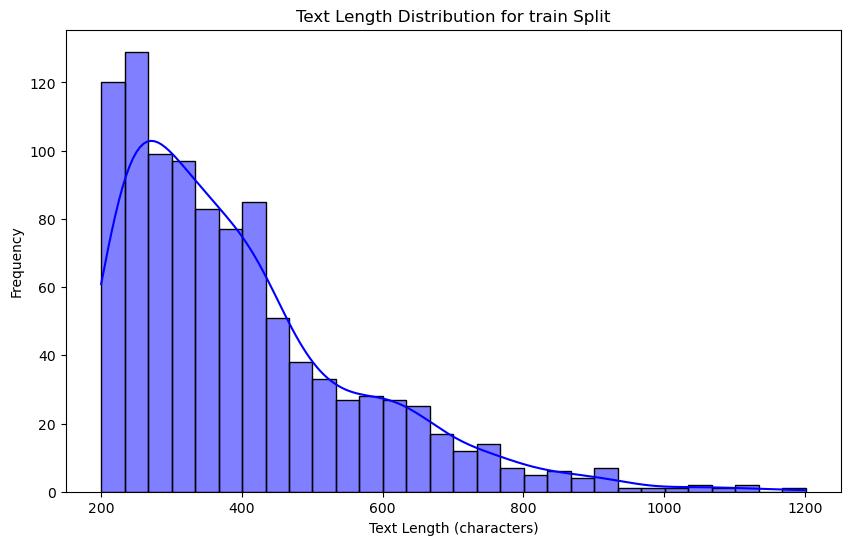

/var/folders/71/mbz03ky907s_r1k5qknpcw300000gn/T/ipykernel_22952/3133149416.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_names, y=style_values, palette='Set2')


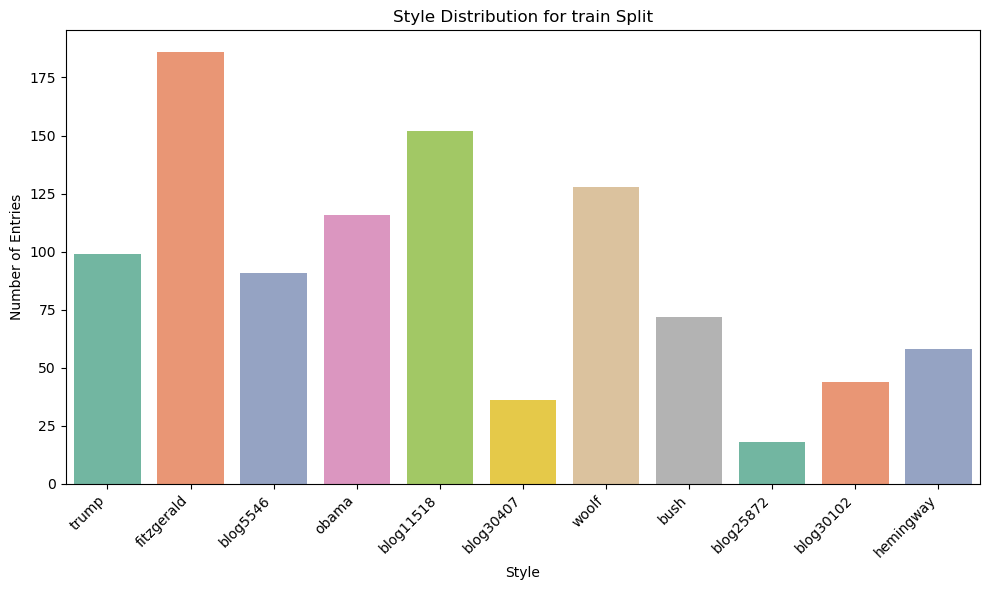

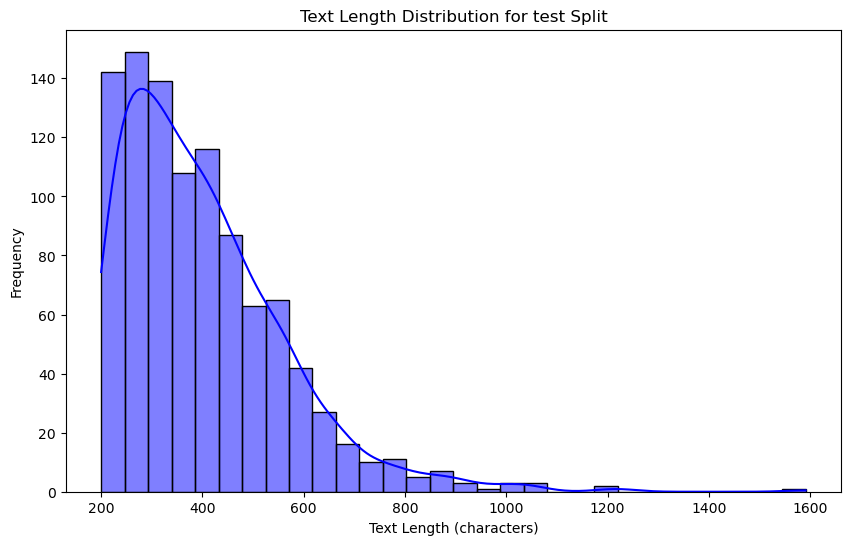

/var/folders/71/mbz03ky907s_r1k5qknpcw300000gn/T/ipykernel_22952/3133149416.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_names, y=style_values, palette='Set2')


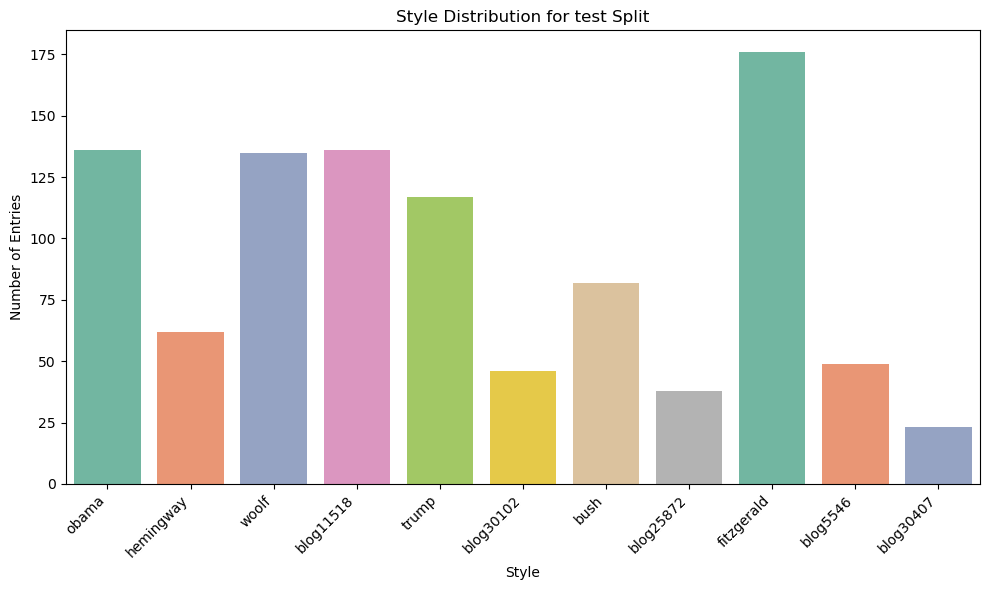


Final Filtered Dataset:
{'train': Dataset({
    features: ['style', 'text', 'category'],
    num_rows: 1000
}), 'test': Dataset({
    features: ['style', 'text', 'category'],
    num_rows: 1000
})}


In [28]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

splits = ["train", "test"]
ds = {
    split: ds for split,
    ds in zip(splits, load_dataset("hallisky/AuthorMix", split=splits))
}

# Function to filter out specific styles and text less than 200 characters
def filter_dataset(dataset, min_text_length=200, styles_to_exclude=None):
    dataset = dataset.filter(lambda example: len(example['text']) >= min_text_length)
    
    if styles_to_exclude:
        dataset = dataset.filter(lambda example: example['style'] not in styles_to_exclude)
    
    return dataset

def plot_text_length_distribution(dataset, split_name):
    text_lengths = [len(example['text']) for example in dataset]
    plt.figure(figsize=(10, 6))
    sns.histplot(text_lengths, bins=30, kde=True, color='blue')
    plt.title(f'Text Length Distribution for {split_name} Split')
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Frequency')
    plt.show()

def display_style_distribution(dataset, split_name):
    style_counts = Counter(dataset['style'])
    style_names, style_values = zip(*style_counts.items())
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=style_names, y=style_values, palette='Set2')
    plt.title(f'Style Distribution for {split_name} Split')
    plt.xlabel('Style')
    plt.ylabel('Number of Entries')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# These are the styles that I have determined to not have enough samples to be useful
styles_to_exclude = ['h', 'pp', 'qq']

for split in splits:
    ds[split] = filter_dataset(ds[split], min_text_length=200, styles_to_exclude=styles_to_exclude)
    
    ds[split] = ds[split].shuffle(seed=42).select(range(1000))
    
    plot_text_length_distribution(ds[split], split)
    
    display_style_distribution(ds[split], split)

print("\nFinal Filtered Dataset:")
print(ds)

In [29]:
filtered_trainer = generate_trainer(ds, lora_config_gpt, "filtered_data")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/david/.cache/huggingface/token
Login successful


/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [30]:
filtered_trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,3.441900,3.186028,0.097000,0.076697,0.097000,0.057527
1,2.236200,2.201617,0.267000,0.323894,0.267000,0.207491
2,1.955300,2.015985,0.318000,0.316140,0.318000,0.250854
4,1.735800,1.846600,0.416000,0.349664,0.416000,0.343681
5,1.521900,1.822877,0.426000,0.360201,0.426000,0.355432


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=336, training_loss=2.6381036667596724, metrics={'train_runtime': 1546.3788, 'train_samples_per_second': 3.492, 'train_steps_per_second': 0.217, 'total_flos': 1425120310591488.0, 'train_loss': 2.6381036667596724, 'epoch': 5.973333333333334})

In [31]:
filtered_trainer.evaluate()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.822877287864685,
 'eval_accuracy': 0.426,
 'eval_precision': 0.3602005763462836,
 'eval_recall': 0.426,
 'eval_f1': 0.355432398118465,
 'eval_runtime': 86.1383,
 'eval_samples_per_second': 11.609,
 'eval_steps_per_second': 5.805,
 'epoch': 5.973333333333334}

## LoRA Parameter Tweaking
Lastly in an effort to improve model performance I'm going to increase the lora_alpha factor to 128, this will give more influence to our low-rank adaptation since I feel we're still underfitting. For this I'm returning to our original dataset to isolate the changes.

In [2]:
# Load the train and test splits of the imdb dataset
splits = ["train", "test"]
ds = {
    split: ds for split,
    ds in zip(splits, load_dataset("hallisky/AuthorMix", split=splits))
}
for split in splits:
    ds[split] = ds[split].shuffle(seed=42).select(range(1000))

# Show the dataset
ds

{'train': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 1000
 }),
 'test': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 1000
 })}

In [18]:
gpt_target_modules = get_lora_target_modules(gpt_model)
lora_config_tweak = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=128,
    lora_dropout=0.1,
    target_modules=gpt_target_modules
)

In [19]:
lora_config_tweak_trainer = generate_trainer(ds, lora_config_tweak, "lora_config_tweak")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/david/.cache/huggingface/token
Login successful


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [20]:
lora_config_tweak_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,2.703800,2.330871,0.269000,0.245800,0.269000,0.198760
1,1.813400,1.890176,0.325000,0.371312,0.325000,0.274799
2,1.572000,1.613826,0.429000,0.421244,0.429000,0.360142
4,1.142800,1.468644,0.501000,0.524230,0.501000,0.471416
5,0.988900,1.479553,0.486000,0.517209,0.486000,0.457017


/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

TrainOutput(global_step=336, training_loss=2.0105587726547602, metrics={'train_runtime': 1545.6942, 'train_samples_per_second': 3.494, 'train_steps_per_second': 0.217, 'total_flos': 1425196412043264.0, 'train_loss': 2.0105587726547602, 'epoch': 5.973333333333334})

In [21]:
lora_config_tweak_trainer.evaluate()

/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.4686439037322998,
 'eval_accuracy': 0.501,
 'eval_precision': 0.5242296540976794,
 'eval_recall': 0.501,
 'eval_f1': 0.47141593274246457,
 'eval_runtime': 83.4447,
 'eval_samples_per_second': 11.984,
 'eval_steps_per_second': 5.992,
 'epoch': 5.973333333333334}